In [3]:
from scipy.stats import poisson
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

## Environment definition

In [8]:
def action_cost_base(action):
    return 2 * abs(action)

def action_cost_modified(action):
    if action > 0:
        return 2 * (action - 1)
    else:
        return 2 * abs(action) 

def parking_cost_base(cars_l1, cars_l2):
    return 0

def parking_cost_modified(cars_l1, cars_l2):
    return 4 * (max(0, cars_l1 - 10) + max(0, cars_l2 - 10))

In [9]:
class CarsEnvironment:
    def __init__(
        self,
        max_cars=20,
        location_1_lambda_rent=3,
        location_1_lambda_return=3,
        location_2_lambda_rent=4,
        location_2_lambda_return=2,
        max_cars_moved=5,
        action_cost=action_cost_base,
        parking_cost=parking_cost_base,
    ):
        self.max_cars = max_cars
        self.location_1_lambda_rent = location_1_lambda_rent
        self.location_1_lambda_return = location_1_lambda_return
        self.location_2_lambda_rent = location_2_lambda_rent
        self.location_2_lambda_return = location_2_lambda_return
        self.max_cars_moved = max_cars_moved
        self.action_cost = action_cost
        self.parking_cost = parking_cost

        self.actions = list(range(-max_cars_moved, max_cars_moved + 1))
        self.states = [(i, j) for i in range(max_cars + 1) for j in range(max_cars + 1)]
        self.non_terminal_states = [state for state in self.states if not self.is_state_terminal(state)]

        self._transition_probability_cache = {}
        self._expected_reward_cache = {}

    def is_state_terminal(state):
        return min(state) == 0

    def single_location_transition_probability(
        self, n_start, n_end, lambda_rent, lambda_return
    ):
        min_rent = max(0, n_start - n_end)

        probability = 0

        for n_rent in range(min_rent, n_start + 1):
            n_return = n_end - n_start + n_rent

            rent_probability = poisson.pmf(n_rent, lambda_rent)

            if n_end < self.max_cars:
                return_probability = poisson.pmf(n_return, lambda_return)
            else:
                return_probability = 1 - poisson.cdf(n_return - 1, lambda_return)

            case_probability = rent_probability * return_probability
            probability += case_probability

        probability += (1 - poisson.cdf(n_start, lambda_rent)) * poisson.pmf(
            n_end, lambda_return
        )

        return probability

    def location_1_transition_probability(self, n_start, n_end):
        return self.single_location_transition_probability(
            n_start, n_end, self.location_1_lambda_rent, self.location_1_lambda_return
        )

    def location_2_transition_probability(self, n_start, n_end):
        return self.single_location_transition_probability(
            n_start, n_end, self.location_2_lambda_rent, self.location_2_lambda_return
        )

    def transition_probability(self, initial_state, final_state, action):
        if (initial_state, final_state, action) in self._transition_probability_cache:
            return self._transition_probability_cache[
                (initial_state, final_state, action)
            ]

        initial_l1, initial_l2 = initial_state
        final_l1, final_l2 = final_state

        initial_l1 -= action
        initial_l2 += action

        if initial_l1 < 0 or initial_l2 < 0:
            raise Exception(f"Invalid action {action} for state {initial_state}")

        initial_l1 = min(self.max_cars, initial_l1)
        initial_l2 = min(self.max_cars, initial_l2)

        probability = self.location_1_transition_probability(
            initial_l1, final_l1
        ) * self.location_2_transition_probability(initial_l2, final_l2)

        self._transition_probability_cache[(initial_state, final_state, action)] = (
            probability
        )

        return probability

    def expected_rentals(self, initial_cars, lambda_rent):
        return (
            sum(poisson.pmf(i, lambda_rent) * i for i in range(initial_cars + 1))
            + (1 - poisson.cdf(initial_cars, lambda_rent)) * initial_cars
        )

    def location_1_expected_rentals(self, n_cars):
        return self.expected_rentals(n_cars, self.location_1_lambda_rent)

    def location_2_expected_rentals(self, n_cars):
        return self.expected_rentals(n_cars, self.location_2_lambda_rent)

    def expected_reward(self, state, action):
        if (state, action) in self._expected_reward_cache:
            return self._expected_reward_cache[(state, action)]

        n_cars_l1, n_cars_l2 = state
        n_cars_l1 -= action
        n_cars_l2 += action

        if n_cars_l1 < 0 or n_cars_l2 < 0:
            raise Exception(f"Invalid action {action} for state {state}")

        n_cars_l1 = min(self.max_cars, n_cars_l1)
        n_cars_l2 = min(self.max_cars, n_cars_l2)

        expected_rent = self.location_1_expected_rentals(
            n_cars_l1
        ) + self.location_2_expected_rentals(n_cars_l2)

        reward = (
            10 * expected_rent
            - self.action_cost(action)
            - self.parking_cost(n_cars_l1, n_cars_l2)
        )

        self._expected_reward_cache[(state, action)] = reward

        return reward

    def valid_state_actions(self, state):
        n_cars_l1, n_cars_l2 = state

        return [
            action
            for action in self.actions
            if n_cars_l1 - action >= 0 and n_cars_l2 + action >= 0
        ]
    
    def is_state_terminal(self, state):
        return min(state) == 0
    
    def compute_transition_probabilities(self):
        state_action_state = [
            (initial_state, final_state, action)
            for initial_state in self.states for final_state in self.states for action in self.valid_state_actions(initial_state)
        ]

        for initial_state, final_state, action in tqdm(state_action_state):
            self.transition_probability(initial_state, final_state, action)

## Policy Iteration

In [57]:
def policy_evaluation(env, value, policy, gamma = 0.9, theta=1e-4):
    while True:
        delta = 0

        for state in env.states:
            v = value[state]
            action = policy[state]

            value[state] = env.expected_reward(state, action) + gamma * sum(
                env.transition_probability(state, next_state, action) * value[next_state]
                for next_state in env.states
            )

            delta = max(delta, abs(v - value[state]))
            # print(state, v, value[state], delta)

        # print(value)

        if delta < theta:
            break

    return value

In [58]:
def policy_improvement(env, value, policy, gamma = 0.9):
    policy_stable = True

    for state in env.states:
        old_action = policy[state]

        policy[state] = max(
            env.valid_state_actions(state),
            key=lambda action: env.expected_reward(state, action)
            + gamma * sum(
                env.transition_probability(state, next_state, action) * value[next_state]
                for next_state in env.states
            ),
        )

        if old_action != policy[state]:
            policy_stable = False

        # print(state, old_action, policy[state])

    return policy, policy_stable

In [88]:
def policy_iteration(env, gamma = 0.9, theta = 1e-4):
    value = {state: 0 for state in env.states}
    policy = {state: 0 for state in env.states}

    policy_history = [policy.copy()]

    while True:
        value = policy_evaluation(env, value, policy, gamma, theta)
        policy, policy_stable = policy_improvement(env, value, policy, gamma)

        if policy_stable:
            break

        policy_history.append(policy.copy())

    return value, policy, policy_history

## Plots for the value function and policy history

In [138]:
def plot_policy_history(env, policy_history):
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

    vmin, vmax = -5, 5  # Set the color scale range

    for i_p, policy in enumerate(policy_history):
        policy_arr = np.array([[policy[(i, j)] for j in range(0, env.max_cars + 1)] for i in range(0, env.max_cars + 1)])
        cax = ax[i_p//3, i_p%3].imshow(policy_arr, origin="lower", vmin=vmin, vmax=vmax)
        ax[i_p//3, i_p%3].set_title(f"Policy {i_p}")

    # Hide the last subplot
    ax[1, 2].axis('off')

    fig.colorbar(cax, ax=ax.ravel().tolist(), shrink=0.7)
    plt.show()

def plot_value_function(env, value):
    value_arr = np.array([[value[(i, j)] for j in range(0, env.max_cars + 1)] for i in range(0, env.max_cars + 1)])

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = np.arange(0, env.max_cars + 1)
    y = np.arange(0, env.max_cars + 1)
    x, y = np.meshgrid(x, y)
    z = value_arr

    ax.plot_surface(x, y, z, cmap='viridis')

    ax.set_xlabel('Cars at Location 1')
    ax.set_ylabel('Cars at Location 2')

    plt.title("Value Function")
    plt.show()

In [ ]:
env = CarsEnvironment()
env.compute_transition_probabilities()

## Original problem replication

In [89]:
value, policy, policy_history = policy_iteration(env)

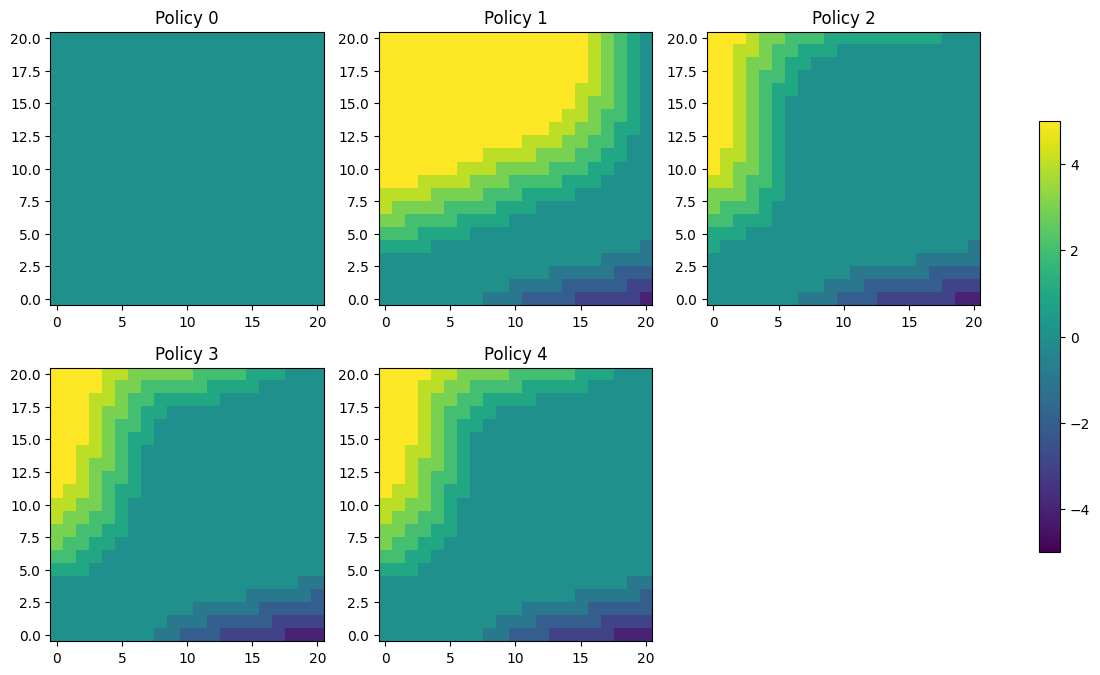

In [86]:
plot_policy_history(env, policy_history)

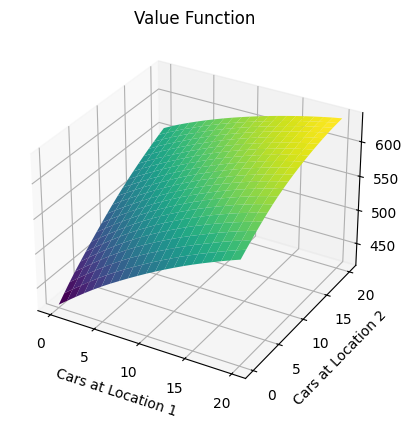

In [ ]:
plot_value_function(env, value)

## Modified problem

In [139]:
env.action_cost = action_cost_modified
env.parking_cost = parking_cost_modified
env._expected_reward_cache = {}

In [140]:
value, policy, policy_history = policy_iteration(env)

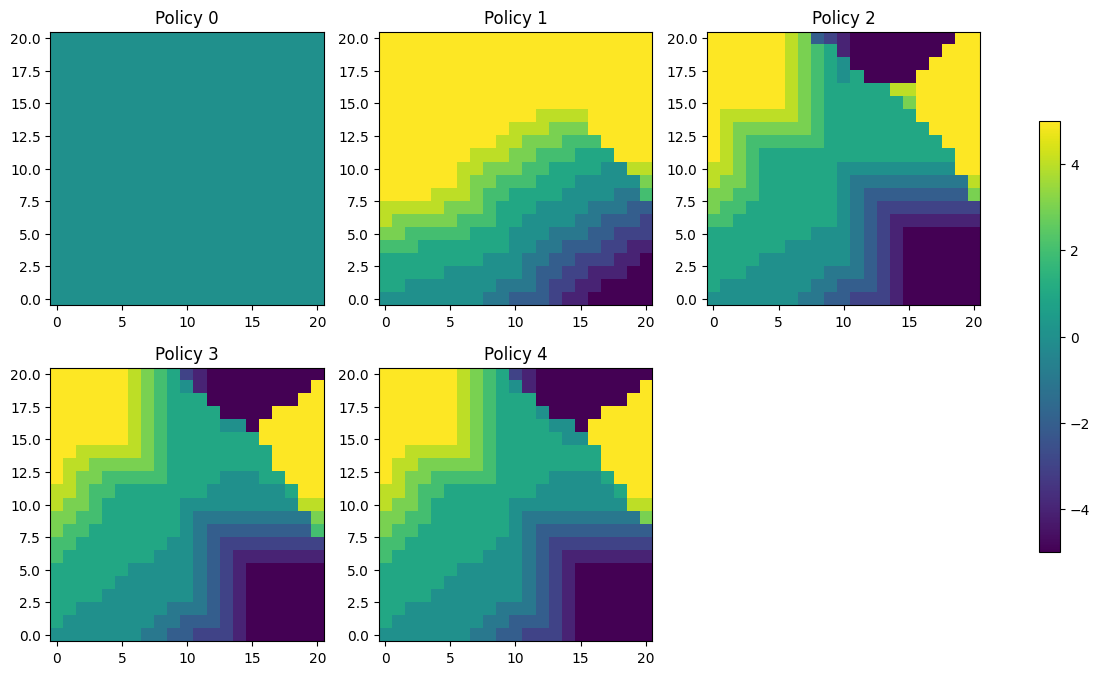

In [141]:
plot_policy_history(env, policy_history)

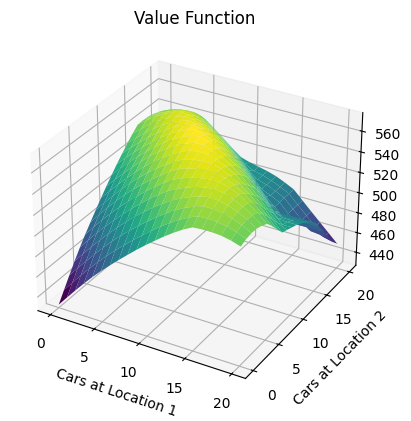

In [143]:
plot_value_function(env, value)